# Лабораторная работа 2. Метод ближайших соседей и решающие деревья.

ФИО: Гой Антон Сергеевич

Группа: 517

In [1]:
import numpy as np
import pandas as pd

Сделаем графики более красивыми:

In [24]:
import matplotlib
matplotlib.style.use('ggplot')

Все эксперименты в этой лабораторной работе предлагается проводить на данных соревнования Amazon Employee Access Challenge: https://www.kaggle.com/c/amazon-employee-access-challenge

В данной задаче предлагается предсказать, будет ли одобрен запрос сотрудника на получение доступа к тому или иному ресурсу. Все признаки являются категориальными.

Для удобства данные можно загрузить по ссылке: https://www.dropbox.com/s/q6fbs1vvhd5kvek/amazon.csv

Сразу прочитаем данные и создадим разбиение на обучение и контроль:

In [2]:
data = pd.read_csv('amazon.csv')
data.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [3]:
data.shape

(32769, 10)

In [4]:
# доля положительных примеров
data.ACTION.mean()

0.94210992096188473

In [5]:
# число значений у признаков
for col_name in data.columns:
    print col_name, len(data[col_name].unique())

ACTION 2
RESOURCE 7518
MGR_ID 4243
ROLE_ROLLUP_1 128
ROLE_ROLLUP_2 177
ROLE_DEPTNAME 449
ROLE_TITLE 343
ROLE_FAMILY_DESC 2358
ROLE_FAMILY 67
ROLE_CODE 343


In [3]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:], data.iloc[:, 0],
                                                    test_size=0.3, random_state=241)

In [7]:
X_train.shape, X_test.shape

((22938, 9), (9831, 9))

## Часть 1: kNN и категориальные признаки

#### 1. Реализуйте три функции расстояния на категориальных признаках, которые обсуждались на втором семинаре. Реализуйте самостоятельно метод k ближайших соседей, который будет уметь работать с этими функциями расстояния. Подсчитайте для каждой из них качество на тестовой выборке `X_test` при числе соседей $k = 10$. Метрика качества — AUC-ROC.

Какая функция расстояния оказалась лучшей?

##### Первая метрика

In [104]:
def knn_first(k, X_train, X_test, y_train, y_test):
    from sklearn.metrics import roc_auc_score
    
    train = X_train.values
    train_targret = y_train.values

    def distance1(y):
        return np.sum(train != y, axis=1)

    probs = [np.mean(train_targret[np.argpartition(distance1(row.values), range(k))[:k]]) 
             for _, row in X_test.iterrows()]
        
    return roc_auc_score(y_test, probs)

knn_first(10, X_train, X_test, y_train, y_test)

0.83244726734770025

##### Третья метрика

In [113]:
def make_knn_third(X_train, X_test, y_train, y_test):
    from sklearn.metrics import roc_auc_score
    
    f_log = {column: np.log(X_train[column].value_counts()) 
             for column in X_train.columns}

    transform = np.frompyfunc(lambda x, y: f_log[x].get(y, 0.0), 2, 1)

    train = X_train.values
    test = X_test.values

    train_target = y_train.values

    train_log = np.array([transform(X_train.columns.values, row) for _, row in X_train.iterrows()])
    test_log = np.array([transform(X_test.columns.values, row) for _, row in X_test.iterrows()])

    def distance3(i, y):
        return np.sum((train != y) * train_log *  test_log[i][np.newaxis, :], axis=1)
    
    def knn_third(k):
        probs = [np.mean(train_target[np.argpartition(distance3(i, y), range(k))[:k]]) for i, y in enumerate(test)]
        return roc_auc_score(y_test, probs)
    
    return knn_third

knn_third = make_knn_third(X_train, X_test, y_train, y_test)
knn_third(10)

0.81705302773806154

##### Вторая метрика

In [6]:
def make_knn_second(X_train, X_test, y_train, y_test):
    from sklearn.metrics import roc_auc_score
    
    l = X_train.shape[0]

    f = {column: X_train[column].value_counts() 
         for column in X_train.columns}
    p = {column: X_train[column].value_counts(normalize=True) 
         for column in X_train.columns}
    p2 = {column: (f[column] * (f[column] - 1)) / (l * (l - 1)) 
          for column in X_train.columns}
    w = {column: {value: p2[column].iloc[i:].sum() for i, value in enumerate(p[column].index)} 
         for column in X_train.columns}

    train = X_train.values
    test = X_test.values
    train_target = y_train.values

    transform = np.frompyfunc(lambda x, y: w[x].get(y, 0.0), 2, 1)

    test_w = np.array([transform(X_test.columns.values, row) for _, row in X_test.iterrows()])

    def distance2(i):
        return np.sum((train != test[i]) + (train == test[i]) * test_w[i], axis=1)

    def knn_second(k):
        probs = [np.mean(train_target[np.argpartition(distance2(i), range(k))[:k]]) for i, _ in enumerate(test)]
        return roc_auc_score(y_test, probs)
    
    return knn_second

knn_second = make_knn_second(X_train, X_test, y_train, y_test)
knn_second(10)

0.850839070800769

#### 2 (бонус). Подберите лучшее (на тестовой выборке) число соседей $k$ для каждой из функций расстояния. Какое наилучшее качество удалось достичь?

#### 3. Реализуйте счетчики (http://blogs.technet.com/b/machinelearning/archive/2015/02/17/big-learning-made-easy-with-counts.aspx), которые заменят категориальные признаки на вещественные.

А именно, каждый категориальный признак нужно заменить на три: 
1. Число `counts` объектов в обучающей выборке с таким же значением признака.
2. Число `clicks` объектов первого класса ($y = 1$) в обучающей выборке с таким же значением признака.
3. Сглаженное отношение двух предыдущих величин: (`clicks` + 1) / (`counts` + 2).

Поскольку признаки, содержащие информацию о целевой переменной, могут привести к переобучению, может оказаться полезным сделать *фолдинг*: разбить обучающую выборку на $n$ частей, и для $i$-й части считать `counts` и `clicks` по всем остальным частям. Для тестовой выборки используются счетчики, посчитанный по всей обучающей выборке. Реализуйте и такой вариант. Можно использовать $n = 3$.

#### Посчитайте на тесте AUC-ROC метода $k$ ближайших соседей с евклидовой метрикой для выборки, где категориальные признаки заменены на счетчики. Сравните по AUC-ROC два варианта формирования выборки — с фолдингом и без. Не забудьте подобрать наилучшее число соседей $k$.

##### Функция для преобразования всех признаков в счетчики для train (можно с фолдингом == n_folds > 1):

In [36]:
from sklearn.cross_validation import KFold

def transform_train_to_counter_features(X_train, y_train,  n_folds=10):
    new_columns = [item for col in X_train.columns  for item in ['COUNTS_%s' % col, 'CLICKS_%s' % col, 'P_%s' % col]]
    X_train_new = pd.DataFrame(index=X_train.index, columns=new_columns)

    if n_folds != 1:
        # with folding
        kfold_object = KFold(y_train.shape[0], n_folds=n_folds, shuffle=True)

        for i, column in enumerate(X_train.columns):
            for train_index, test_index in kfold_object: 
                test_values = X_train.iloc[test_index, i]
                train_values = X_train.iloc[train_index, i]

                counts = train_values.value_counts()

                clicks = counts.copy()
                clicks[:] = 0
                clicks += train_values[y_train.iloc[train_index] == 1].value_counts()
                p = (clicks + 1) / (counts + 2)

                counts = counts[test_values]
                clicks = clicks[test_values]
                p = p[test_values]

                counts.fillna(0, inplace=True)
                clicks.fillna(0, inplace=True)
                p.fillna(0.5, inplace=True)

                count_name = 'COUNTS_%s' % column
                clicks_name = 'CLICKS_%s' % column
                p_name = 'P_%s' % column
                
                counts.index = test_values.index
                clicks.index = test_values.index
                p.index = test_values.index

                X_train_new.loc[test_values.index, count_name] = counts
                X_train_new.loc[test_values.index, clicks_name] = clicks
                X_train_new.loc[test_values.index, p_name] = p
    else:
        # without folding
        for i, column in enumerate(X_train.columns):
            counts = X_train[column].value_counts()
    
            clicks = counts.copy()
            clicks[:] = 0
            clicks += X_train.loc[y_train == 1, column].value_counts()
    
            p = (clicks + 1.).div(counts + 2., axis=0)
        
            counts.fillna(0, inplace=True)
            clicks.fillna(0, inplace=True)
            p.fillna(0.5, inplace=True)
        
            count_name = 'COUNTS_%s' % column
            clicks_name = 'CLICKS_%s' % column
            p_name = 'P_%s' % column
            
            counts = counts[X_train[column]]
            clicks = clicks[X_train[column]]
            p = p[X_train[column]]
            
            counts.index = X_train.index
            clicks.index = X_train.index
            p.index = X_train.index
            
            X_train_new.loc[:, count_name] = counts
            X_train_new.loc[:, clicks_name] = clicks
            X_train_new.loc[:, p_name] = p
            
    return X_train_new

X_train_folding = transform_train_to_counter_features(X_train, y_train, n_folds=1)

#####  Функция для преобразования всех признаков в счетчики для test:

In [37]:
def transform_test_to_counter_features(X_test, X_train, y_train):
    new_columns = [item for col in X_test.columns  for item in ['COUNTS_%s' % col, 'CLICKS_%s' % col, 'P_%s' % col]]
    X_test_new = pd.DataFrame(index=X_test.index, columns=new_columns)

    for column in X_test.columns:
        counts = X_train[column].value_counts()

        clicks = counts.copy()
        clicks[:] = 0
        clicks += X_train.loc[y_train == 1, column].value_counts()

        p = (clicks + 1.).div(counts + 2., axis=0)

        counts = counts[X_test[column]]
        clicks = clicks[X_test[column]]
        p = p[X_test[column]]

        counts.index = X_test.index
        clicks.index = X_test.index
        p.index = X_test.index

        counts.fillna(0, inplace=True)
        clicks.fillna(0, inplace=True)
        p.fillna(0.5, inplace=True)

        count_name = 'COUNTS_%s' % column
        clicks_name = 'CLICKS_%s' % column
        p_name = 'P_%s' % column

        X_test_new.loc[:, count_name] = counts
        X_test_new.loc[:, clicks_name] = clicks
        X_test_new.loc[:, p_name] = p
        
    return X_test_new
        
X_test_folding = transform_test_to_counter_features(X_test, X_train, y_train)

##### Подбираем число соседей и количество фолдов:

In [583]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

results = pd.DataFrame(columns=['AUC', 'N_FOLDS', 'K_NEIGHBORS'], index=range(6 * len(range(1, 60, 5))))
test = transform_test_to_counter_features(X_test, X_train, y_train)

i = 0
for n in [1, 3, 10, 50, 100, 1000]:
    train = transform_train_to_counter_features(X_train, y_train, n_folds=n)
    for k in range(1, 60, 5):
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(train, y_train)
        predictions = model.predict_proba(test)
        auc = roc_auc_score(y_test, predictions[:, 1])
        results.loc[i, ['AUC', 'N_FOLDS', 'K_NEIGHBORS']] = [auc, n, k]
        i += 1

##### Результаты:

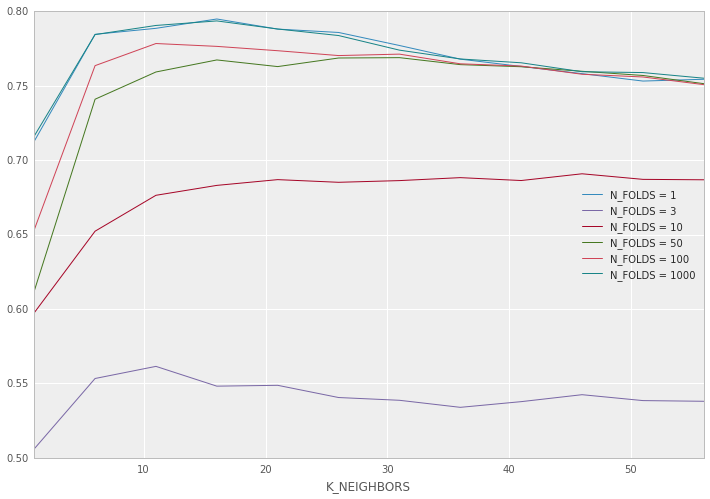

In [586]:
ax = results[results.N_FOLDS == 1].plot(x='K_NEIGHBORS', y='AUC', label='N_FOLDS = 1', figsize=(12, 8))
results[results.N_FOLDS == 3].plot(x='K_NEIGHBORS', y='AUC', label='N_FOLDS = 3', ax=ax)
results[results.N_FOLDS == 10].plot(x='K_NEIGHBORS', y='AUC', label='N_FOLDS = 10',ax=ax)
results[results.N_FOLDS == 50].plot(x='K_NEIGHBORS', y='AUC', label='N_FOLDS = 50', ax=ax)
results[results.N_FOLDS == 100].plot(x='K_NEIGHBORS', y='AUC', label='N_FOLDS = 100', ax=ax)
results[results.N_FOLDS == 1000].plot(x='K_NEIGHBORS', y='AUC', label='N_FOLDS = 1000', ax=ax)

##### Лучшие результаты:

In [592]:
results.loc[results.groupby('N_FOLDS')['AUC'].idxmax(), ]

,AUC,N_FOLDS,K_NEIGHBORS
3,0.794899,1,16
14,0.561442,3,11
33,0.690871,10,46
42,0.768925,50,31
50,0.778412,100,11
63,0.793608,1000,16


#### 4. Добавьте в исходную выборку парные признаки — то есть для каждой пары $f_i$, $f_j$ исходных категориальных признаков добавьте новый категориальный признак $f_{ij}$, значение которого является конкатенацией значений $f_i$ и $f_j$. Посчитайте счетчики для этой выборки, найдите качество метода $k$ ближайших соседей с наилучшим $k$ (с фолдингом и без).

##### Функция, которая создает новую обучающую и тестовую выборку с добавленными признаками:

In [9]:
def add_concat_features(X_train, X_test):
    X_train_new = X_train.copy()
    X_test_new = X_test.copy()
    
    X_train_new = X_train_new.apply(lambda x: x.astype(str))
    X_test_new = X_test_new.apply(lambda x: x.astype(str))
    
    for i, f_i in enumerate(X_train.columns):
        for j, f_j in enumerate(X_train.columns):
            if i < j:
                new_column_name = '%s_%s' % (f_i, f_j)
                X_train_new[new_column_name] = [''.join([e1, e2])
                    for e1, e2 in zip(X_train_new[f_i].values, X_train_new[f_j].values)]
#                 X_train_new.loc[:, [f_i, f_j]].apply(lambda x: ''.join(x[[f_i, f_j]]), axis=1)
                X_test_new[new_column_name] = [''.join([e1, e2])
                    for e1, e2 in zip(X_test_new[f_i].values, X_test_new[f_j].values)]
#                 X_test_new.loc[:, [f_i, f_j]].apply(lambda x: ''.join(x[[f_i, f_j]]), axis=1)
                
    X_train_new = X_train_new.apply(lambda x: x.astype(np.int64))
    X_test_new = X_test_new.apply(lambda x: x.astype(np.int64))
    
    return X_train_new, X_test_new

X_train_concat, X_test_concat = add_concat_features(X_train, X_test)

##### Подбираем число соседей и количество фолдов:

In [22]:
results_concat = pd.DataFrame(columns=['AUC', 'N_FOLDS', 'K_NEIGHBORS'], index=range(3 * len(range(1, 60, 5))))
test = transform_test_to_counter_features(X_test_concat, X_train_concat, y_train)

i = 0
for n in [1, 3, 10]:
    train = transform_train_to_counter_features(X_train_concat, y_train, n_folds=n)
    for k in range(1, 60, 5):
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(train, y_train)
        predictions = model.predict_proba(test)
        auc = roc_auc_score(y_test, predictions[:, 1])
        results_concat.loc[i, ['AUC', 'N_FOLDS', 'K_NEIGHBORS']] = [auc, n, k]
        i += 1

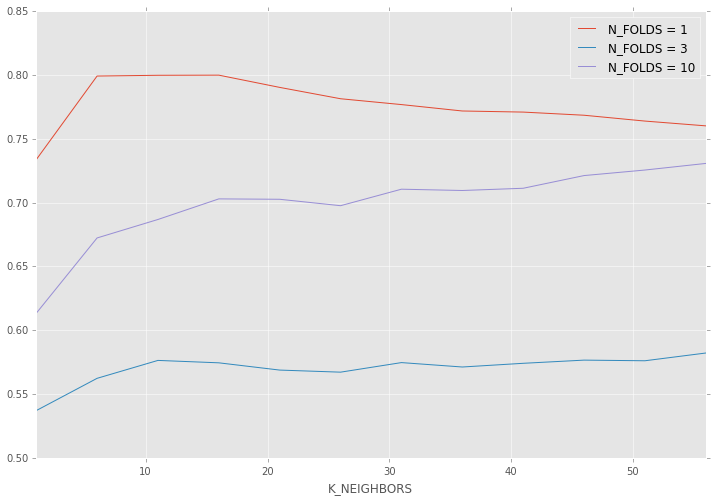

In [30]:
ax = results_concat[results_concat.N_FOLDS == 1].plot(x='K_NEIGHBORS', y='AUC', label='N_FOLDS = 1', figsize=(12, 8))
results_concat[results_concat.N_FOLDS == 3].plot(x='K_NEIGHBORS', y='AUC', label='N_FOLDS = 3', ax=ax)
results_concat[results_concat.N_FOLDS == 10].plot(x='K_NEIGHBORS', y='AUC', label='N_FOLDS = 10',ax=ax)

## Часть 2: Решающие деревья и леса

#### 1. Возьмите из предыдущей части выборку с парными признаками, преобразованную с помощью счетчиков без фолдинга. Настройте решающее дерево, подобрав оптимальные значения параметров `max_depth` и `min_samples_leaf`. Какой наилучший AUC-ROC на контроле удалось получить?

In [39]:
X_train_new = transform_train_to_counter_features(X_train_concat, y_train, n_folds=1) 
X_test_new = transform_test_to_counter_features(X_test_concat, X_train_concat, y_train) 

In [68]:
from sklearn.ensemble import RandomForestClassifier

n = len(range(1, 50, 10)) * len(range(1, 500, 50))

results_rf1 = pd.DataFrame(columns=['AUC', 'DEPTH', 'LEAF_SIZE'], index=range(n))

i = 0
for depth in range(5, 51, 9):
    for size in range(50, 700, 50):
        rf_model = RandomForestClassifier(max_depth=depth, min_samples_leaf=size, n_jobs=-1)
        rf_model.fit(X_train_new, y_train)
        predictions = rf_model.predict_proba(X_test_new)
        auc = roc_auc_score(y_test, predictions[:, 1])
        results_rf1.loc[i, ['AUC', 'DEPTH', 'LEAF_SIZE']] = [auc, depth, size]
        i += 1

##### Результаты (Нестабильный графики объясняются тем, что слишком мало деревьев)

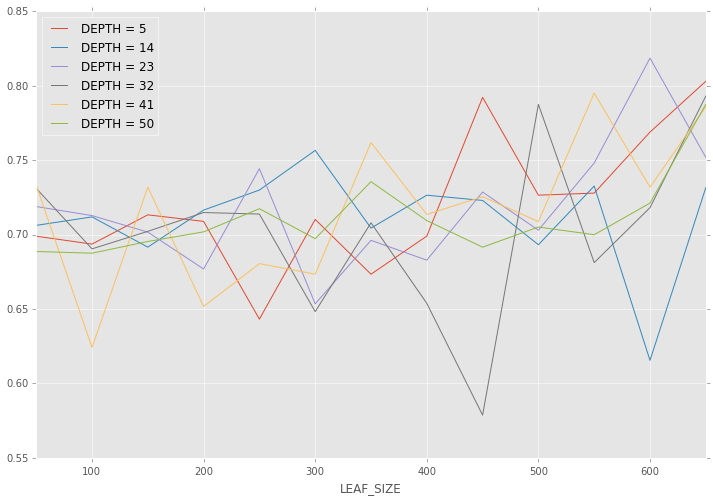

In [69]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for depth in results_rf1.DEPTH.unique():
    results_rf1[results_rf1.DEPTH == depth].plot(x='LEAF_SIZE', y='AUC', label='DEPTH = %d' % depth, ax=ax, figsize=(12, 8))

#### 2. Настройте случайный лес, подобрав оптимальное число деревьев `n_estimators`. Какое качество на тестовой выборке он дает?

In [73]:
results_rf2 = pd.DataFrame(columns=['AUC', 'N_ESTIMATORS'], index=range(14))
i = 0
for n in [1, 5, 10, 20, 50, 75, 100, 125, 150, 175, 200, 250, 300, 350]:
        rf_model = RandomForestClassifier(n_estimators=n, n_jobs=-1)
        rf_model.fit(X_train_new, y_train)
        predictions = rf_model.predict_proba(X_test_new)
        auc = roc_auc_score(y_test, predictions[:, 1])
        results_rf2.loc[i, ['AUC', 'N_ESTIMATORS']] = [auc, n]
        i += 1

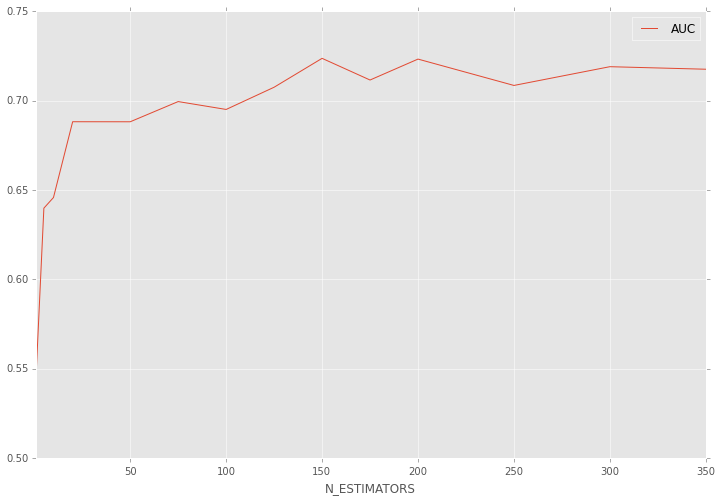

In [77]:
results_rf2.plot(x='N_ESTIMATORS', y='AUC', figsize=(12, 8))

#### 3. Возьмите выборку с парными признаками, для которой счетчики посчитаны с фолдингом. Обучите на ней случайный лес, подобрав число деревьев. Какое качество на тестовой выборке он дает? Чем вы можете объяснить изменение результата по сравнению с предыдущим пунктом?

In [78]:
X_train_new = transform_train_to_counter_features(X_train_concat, y_train, n_folds=10) 
X_test_new = transform_test_to_counter_features(X_test_concat, X_train_concat, y_train) 

In [79]:
results_rf3 = pd.DataFrame(columns=['AUC', 'N_ESTIMATORS'], index=range(14))
i = 0
for n in [1, 5, 10, 20, 50, 75, 100, 125, 150, 175, 200, 250, 300, 350]:
        rf_model = RandomForestClassifier(n_estimators=n, n_jobs=-1)
        rf_model.fit(X_train_new, y_train)
        predictions = rf_model.predict_proba(X_test_new)
        auc = roc_auc_score(y_test, predictions[:, 1])
        results_rf3.loc[i, ['AUC', 'N_ESTIMATORS']] = [auc, n]
        i += 1

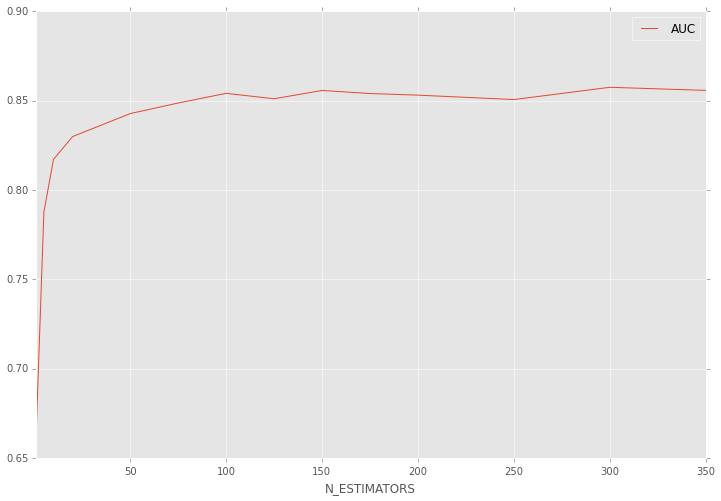

In [80]:
results_rf3.plot(x='N_ESTIMATORS', y='AUC', figsize=(12, 8))

При помощи фолдинга мы избавились от переобучения, поэтому результат в последнем пункте на 0.12 больше чем во втором.